# Task Definition

A mining company has rocks passing over a conveyer belt of all different sizes and qualities. They need to seperate the rocks depending on their class so the rocks can be dsitrubuted to the correct place. Currently this classification and separation is done by labourers and they want to automate this process to reuce costs and improve efficiency and accuracy. 

A camera was psoitoned above the conveyer belt at a certain point and thousands of images were taken of the rocks. These images have been provided to us. The images are all unlabelled apart from a few example images for each class. 


# Notebook Setup

The fastai libary is a high-level library built on PyTorch. Fastai is focused on making machine learning models easy to use with great performance and accessible to the masses.  

The code is completely open source and anyone can contribute to the library. Fastai has been a gamechanger in the machine learning communtiy and enabled people from all different backgrounds and industries to benefit free of charge. 

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.8MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 194kB 13.2MB/s 
     |████████████████████████████████| 1.0MB 9.7MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 40kB 5.8MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 2.6MB 21.7MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.data.all import *
from fastai.vision.all import *
from pathlib import Path

# Project Workflow

- Data exploration
- Manual Data Classification
- Outlier Detection
- Training of labelled data
- Getting pseudo labels
- Utilizing Unlabelled data for training
- Tuning Model
- Export predicted results
- End Project

# Exploratory Data Analysis

In our exploratory data analysis step, we looked at the various images that were given for training. This involved manualy sifting through a number of images to see the kind of images given as well as drawing some histogram plots to check the color distribution of the images.
We noticed that:

- There were a number of images that could not be attributed to any of the 5 classes i.e chip, pellets, fines, lump or mixed

- There were various images that were difficult to identify because they were either *blurry*, have some *obstruction*, have *shadow*

- Some images were blank; either black or grey in color.

Loading Data

In [ ]:
#example_data_path = Path('/content/gdrive/Shared drives/DSI Shared Folder/Module 2/DSI_module2_data.zip (Unzipped Files)/examples')
example_data_path = Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/examples')
sample_data_path = Path('/content/gdrive/Shared drives/DSI Shared Folder/Module 2/DSI_module2_data.zip (Unzipped Files)/samples')
example_data_path.ls()

(#6) [Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/examples/.DS_Store'),Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/examples/lump'),Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/examples/chip'),Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/examples/mixed'),Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/examples/fines'),Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/examples/pellets')]

The five folders in the example folder are the five classes of rocks. Each folder contains example images of the class. Let's look at the images in each class. 

The Python Imaging Library `PIL` can be used for basic image handling methods. The images were read from the path variable and displayed using the `Matplotlib` `subplot` function. 


chip


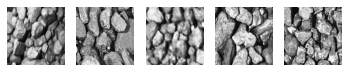

fines


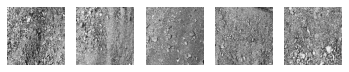

lump


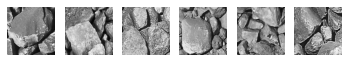

mixed


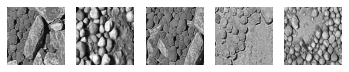

pellets


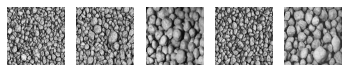

In [ ]:
import matplotlib.pyplot as plt
import PIL
from PIL import Image
%matplotlib inline

classes = ['chip','fines','lump', 'mixed', 'pellets']
plt.figure()

for c in classes:
  print(c)
  c_path = example_data_path/c
  i=0
  for img_p in c_path.ls():
    sp = plt.subplot(1, len(c_path.ls()), i+1)
    sp.axis('off')
    img = PIL.Image.open(img_p)
    plt.imshow(img)
    i+=1

  plt.show()

##  More Image Analysis
The plots below give us another way of understanding the images. We get intuition about contrast, brightness, intensity distribution etc of the image. For each image shown, a histogram of its intensity for different pixel values is plotted below it.

The left region of the histogram shows the amount of darker pixels in image and right region shows the amount of brighter pixels. The x axis goes from 0, the darkest (black) to 1, the lightest (white). 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

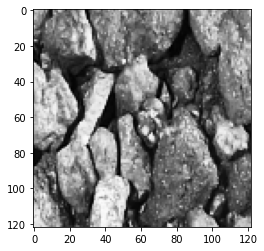

In [ ]:
img = plt.imread("./gdrive/Shared drives/DSI Module 2 Team Drive /Data/samples/img_8.png")
plt.imshow(img)

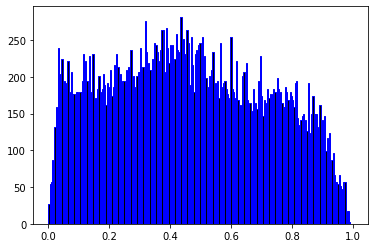

In [ ]:
plt.hist(img.ravel(), bins = 256, range = (0.0, 1.0),fc = 'k', ec="blue"); plt.show()

The above diagram shows that the image above it has almost the same amount of dark and lighter pixels.

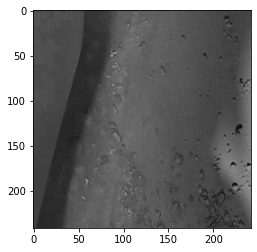

In [ ]:
img2 = plt.imread("./gdrive/Shared drives/DSI Module 2 Team Drive /Data/samples/img_103.png")
plt.imshow(img2)

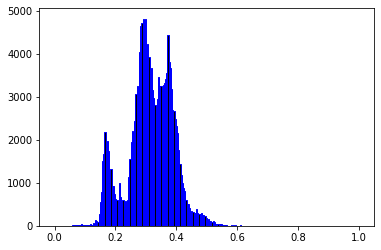

In [ ]:
diag = plt.hist(img2.ravel(), bins = 256, range = (0.0, 1.0), fc= 'k', ec='blue');plt.show()

The histogram above shows that the image has more dark pixels than light ones

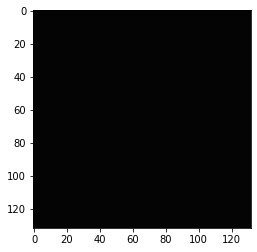

In [ ]:
img3 = plt.imread("./gdrive/Shared drives/DSI Module 2 Team Drive /Data/samples/img_484.png")
plt.imshow(img3)

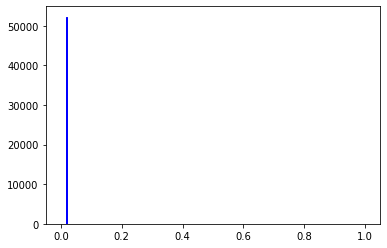

In [ ]:
plt.hist(img3.ravel(), bins = 256, range = (0.0, 1.0), fc= 'k', ec='blue');plt.show()

The histogram above is from one of the images that were in the dataset that was given. such an image would make our model perform poorly because it doesn't fall under any category. We then had to think of a way of dealing with such images. We decided to take the following two steps:


- Manual Data Classification - This acted as the training data for our anomaly/outlier detector model as well as initial training data for our classification model

- Training an outlier detector model - We trained an outlier detector model and used it to remove the anomalies from the unlabelled data which we later use in our model.

# Manual Data Classification

Since there were only 5 or 6 example labelled images per class, we needed to get more labelled data for training. We started by manually sorting images from the samples folder into folders for each class. The enlarged dataset was then loaded to the notebook.

The data needed to be converted to a PyTorch `dataloader ` for the model training. This can be done using the Fastai `DataBlock` API. 

**Fastai DataBlock API**

The `DataBlock` API is used to create data objects that store information about the data including the type of data, how to get the data, how to split the data, labelling the items, processing methods such as transforms, augmentation and normalization and whether the data should be batched. PyTorch  datasets and dataloaders can then be built from these objects and fed to the model for training and testing.

A DataBlock object is created for the rock image data. The parameter block is set to ImageBlock for the inputs as our inputs are image files, and CategoryBlock for the output as our model needs to try classifiy the input images into its correct category. The splitter splits the input data into a training set and validation set. get_items and get_y determine how to get the input data and how to get the output data or targets respectively. 

The item_tfms parameter is used to define transformations that should be applied to each item in the input data. A Resize transformation is applied to set all the input images to the same size. The batch_tfms parameter allows us to define transformations that should be applied to each batch of input data. The method auf_transforms applies several default transformations to the input data as the the model is trained so the model is trained on different augmented versions of the origianl images throughtout the training loop. This improves th performance of the model as it receives a greater representation of image features. 

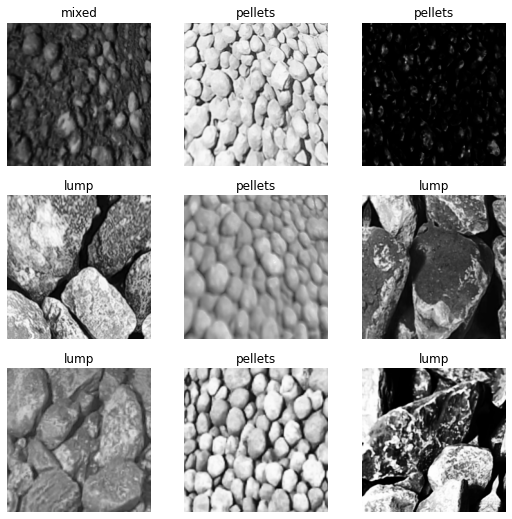

In [ ]:
data_path = Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /DATA FINAL')

block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  splitter = RandomSplitter(),
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=Resize(224),
                  batch_tfms=aug_transforms(do_flip=True, max_lighting=.8)
                  )


#create dataloader from DataBlock object
dls = block.dataloaders(data_path, bs=64)
dls.show_batch()

In [ ]:
for c in classes:
  c_path = data_path/c
  print(c, ': ', len(c_path.ls()))

chip :  943
fines :  579
lump :  1041
mixed :  691
pellets :  1192


From the above, we managed to get the following number of images to their respective classes:

**chip** - 943

**fines** - 579

**lump** - 1041

**mixed** - 691

**pellets** - 1192

In [ ]:
import fastai
fastai.__version__

'2.0.16'

# Anomaly Detector
From our exploration of the data  above, we saw that there were some images that were outside the "normal distribution" of what rocks look like and this would greatly affect the performance of the model.

This led us to building an anomaly detection model to sift through our data and remove the anomaly images.


ref:(https://www.pyimagesearch.com/2020/01/20/intro-to-anomaly-detection-with-opencv-computer-vision-and-scikit-learn/)




In [ ]:
from imutils import paths
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import the necessary packages
from sklearn.ensemble import IsolationForest
import argparse
import pickle

import argparse
import pickle
import cv2

The following function is used to quantify and characterize the contents of our input images, it basically characterises the color distribution of an image

In [ ]:
def quantify_image(image, bins=(4, 6, 3), draw=False):
    # compute a 3D color histogram over the image and normalize it
    hist = cv2.calcHist([image], [0, 1, 2], None,
                        bins, [0, 180, 0, 256, 0, 256])
    normHist = cv2.normalize(hist, hist).flatten()
    # if draw == True:
    #    color = ('b', 'g', 'r')
    #    for i, col in enumerate(color):
    #        plt.plot(hist[i], color=col)
    #        plt.xlim([0, 6])
    #    plt.show()
    # return the histogram
    return normHist

We then combined the data that we had initially classified and used it for training our outlier detector. The following code is used to grab the paths to all these images then quantify them using the quantifier image function above.

In [ ]:
def load_dataset(datasetPath, bins):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    # loop over the image paths
    for imagePath in imagePaths:
        # load the image and convert it to the HSV color space
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # quantify the image and update the data list
        features = quantify_image(image, bins)
        data.append(features)
    # return our data list as a NumPy array
    return np.array(data)

## Training the Outlier Detector

Here we load in the data previously classified and use it for training

In [ ]:
# load and quantify our image dataset
print("[INFO] preparing dataset...")
# put all the classified images into one folder
path = "./gdrive/Shared drives/DSI Module 2 Team Drive /Computer Vision Challenge Shared Folder/Fixmatch Notebooks/clean_rocks/"

#loading the dataset
data = load_dataset(path, bins=(3, 3, 3))

[INFO] preparing dataset...


In [ ]:
# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")

#use the isolation forest to train the anomaly detection model
model = IsolationForest(n_estimators=100, contamination=0.01,
	random_state=42)
model.fit(data)

save the trained model


In [ ]:
# serialize the anomaly detection model to disk
f = open("./gdrive/Shared drives/DSI Module 2 Team Drive /Computer Vision Challenge Shared Folder/Fixmatch Notebooks/models/anomaly_detector.model", "wb")
f.write(pickle.dumps(model))
f.close()

Now that the model is trained and saved, we loaded it and put it to use. The function below loops through all the unlabelled images that will be used for training and moves the anomaly images to a different folder, leaving our initial folder with cleaner and more useful images which will be ready for training.

In [ ]:
# load the anomaly detection model
print("[INFO] loading anomaly detection model...")
path_model = "/content/gdrive/Shared drives/DSI Module 2 Team Drive /Computer Vision Challenge Shared Folder/Fixmatch Notebooks/models/anomaly_detector.model"
model = pickle.loads(open(path_model, "rb").read())

We created a folder *anomaly* where we moved the out of distribution data that was found in the unlabelled data


**WARNING** This code takes a while to run

In [ ]:
import os
import shutil

filenames = []

directory = "./gdrive/Shared drives/DSI Module 2 Team Drive /Data/samples/"

# directory to the sampled images for testing model
directory2 = ""
for filename in os.listdir(directory):
  count+=1
  print(f'{count}\r', end="")
  filename = str(filename)
  image = cv2.imread(directory + filename)
  image = image.astype('uint8')

  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  features = quantify_image(hsv, bins=(3, 3, 3))
  preds = model.predict([features])[0]

  '''
  we used the code below to move the anomaly images to a different folder called anomaly
  '''
  #if preds == -1 it means that image is an anomaly
  if preds == -1:
    #moves the images that fall under anomaly to a folder called anomaly
    shutil.move(directory +filename, "./drive/My Drive/anomaly/")
    filenames.append(filename)

Now our samples folder is made up of good unlabelled images which are suitable for training our model 

# Pseudo-labelling 

Pseudo labelling is the process of adding confident predicted test data into our training data. It usually involves a number of tests:


1.   Building a model using training data
2.   Predict the labels for a batch of unseen unlabeled dataset.
3.   Add confident observations to our training data.
4.   Build a new model using the combined data

The following code shows our attempt at creating pseudo labels. 

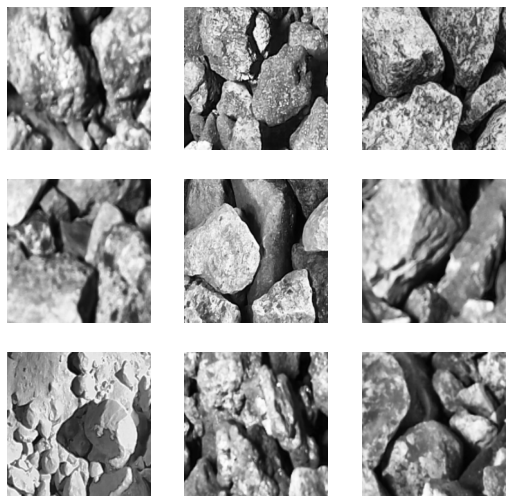

In [ ]:
unlabelled_path = Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/samples')
unlabelled_path2 = Path('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/samples_new')

images_n = get_image_files(unlabelled_path2)

# an unlabelled dataloader for predictions is created with same properties as main dataloader dls
dl_unlabelled = dls.test_dl(images_n)
dl_unlabelled.show_batch()

A cnn_learner model was created with a pretrained resnet34. 

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


To find a good learning rate we used the fastai learning rate finder function, `lr_find`,  to plot the loss over a range of learning rates. 

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0014454397605732083)

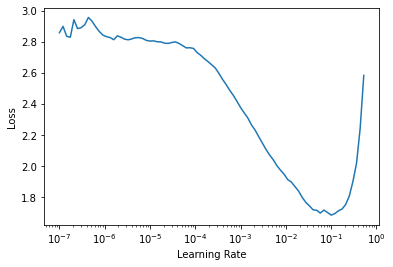

In [ ]:
learn.lr_find()

The loss is a minimum when the learning rate is around 1e-1. A good learning rate is where the gradient of the loss plot is at its steepest about an order of magnitude below the minimum. Therefore, the learning rate is chosen to be 1e-2. 

In [ ]:
learn.fit_one_cycle(6, 1e-2)

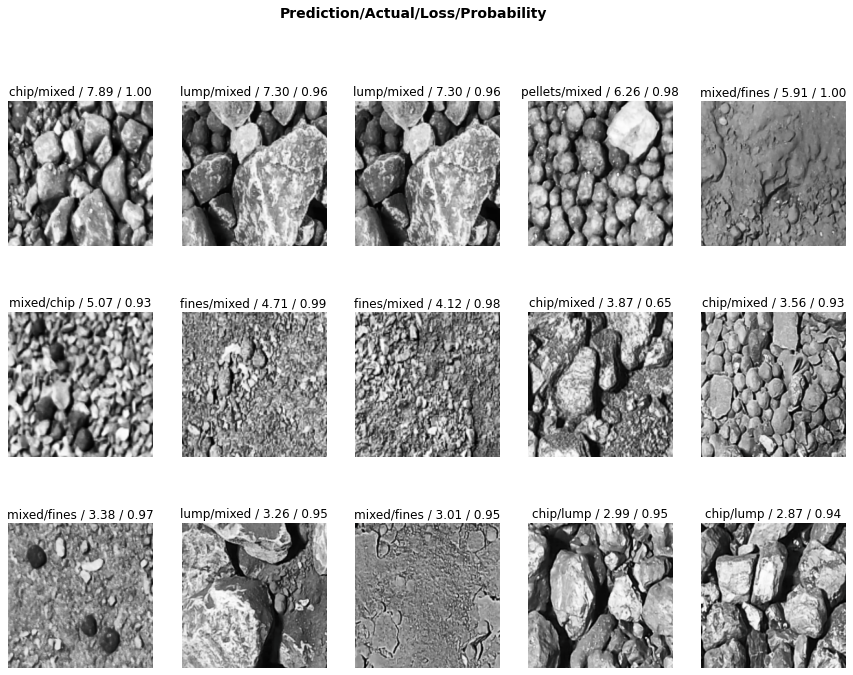

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

interp.plot_top_losses(15, figsize=(15,11))

In [ ]:
learn.save('learner_1')

Path('models/learner_1.pth')

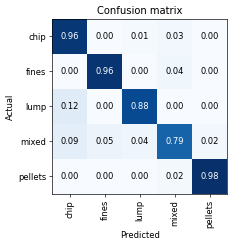

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60, normalize = True)

3 models were used for predicting pseudo-labels. If they all predicted the same class with an above 0.9 confidence then the pseudo-labelled image was saved. 

In [ ]:
learn2 = learn
learn3 = learn

learn2.fine_tune(1)
learn3.fine_tune(2)

In [ ]:
preds1 = learn.tta(dl = dls.test_dl(images_n))
preds2 = learn2.tta(dl = dls.test_dl(images_n))
preds3 = learn3.tta(dl = dls.test_dl(images_n))

In [ ]:
import shutil

#classes = dls.classes.   

#tensor to numpy arrays
pred1_np = preds1[0].numpy()
pred2_np = preds2[0].numpy()
pred3_np = preds3[0].numpy()

#if all models predict a class with confidence greater than 90% save pseudo-labelled image
confident = (pred1_np>0.9)*(pred2_np>0.9)*(pred3_np>0.9)
rows = confident.shape[0]
cols = confident.shape[1]

for i in range(0, rows):
    for c in range(0, cols):
      if confident[i, c] ==True:
          cls = classes[c]
          print(f'{i} -> {cls}')
          shutil.copy(images_n[i], Path(f'/content/gdrive/Shared drives/DSI Module 2 Team Drive /Pseudolabelled Data/{cls}'))


#average predictions of models -> decided to rather use if all models are above threshold

#pred_avg = (preds1[0]+preds2[0]+preds3[0])/3
#max_pred, idcs = torch.max(pred_avg, 1)
#max_pred.size()

#for idx, p in enumerate(max_pred):
#  if p>= 0.9:
#    cls = classes[idcs[idx]]
#    print(f'{idx} : {p.item()} -> {cls}')
#    shutil.copy(images_n[idx], Path(f'/content/gdrive/Shared drives/DSI Module 2 Team Drive /Pseudolabelled Data/{cls}'))

# FixMatch
This is a semi-surpervised learning algorithm that combines consistency regularization and pseudo labeling to make use of unlabeled data.

If a prediction is above a confidence threshold, it is retained as a pseudo-label. The model is then trained to predict the same pseudo-label from a strongly augmented version of the same image.

ref(https://github.com/phanav/fixmatch-fastai/blob/master/fixmatch_fastai_phanav_v3.ipynb)


**NOTE**: For the below code to work, we need to downgrade to Fastai Version 1


In [ ]:
! pip install fastai==1.0.61

In [ ]:
#import the necessary libaries
import os
from pathlib import Path
import sys
import pdb
import logging
import traceback

import pandas as pd

from functools import partial

import fastai
from fastai.vision import *

from fastai.basic_train import LearnerCallback, Learner, DataBunch, SmoothenValue, to_data, functools, \
    add_metrics, Module, nn
from fastai.imports import torch, F

import numpy as np
from torch.utils.data import Dataset

from numbers import Integral
import gc

import torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


FastAI uses ImageDataBunch function as one of the ways of loading in images. Here we load in the labelled/classified images and explore if they've been loaded correctly.

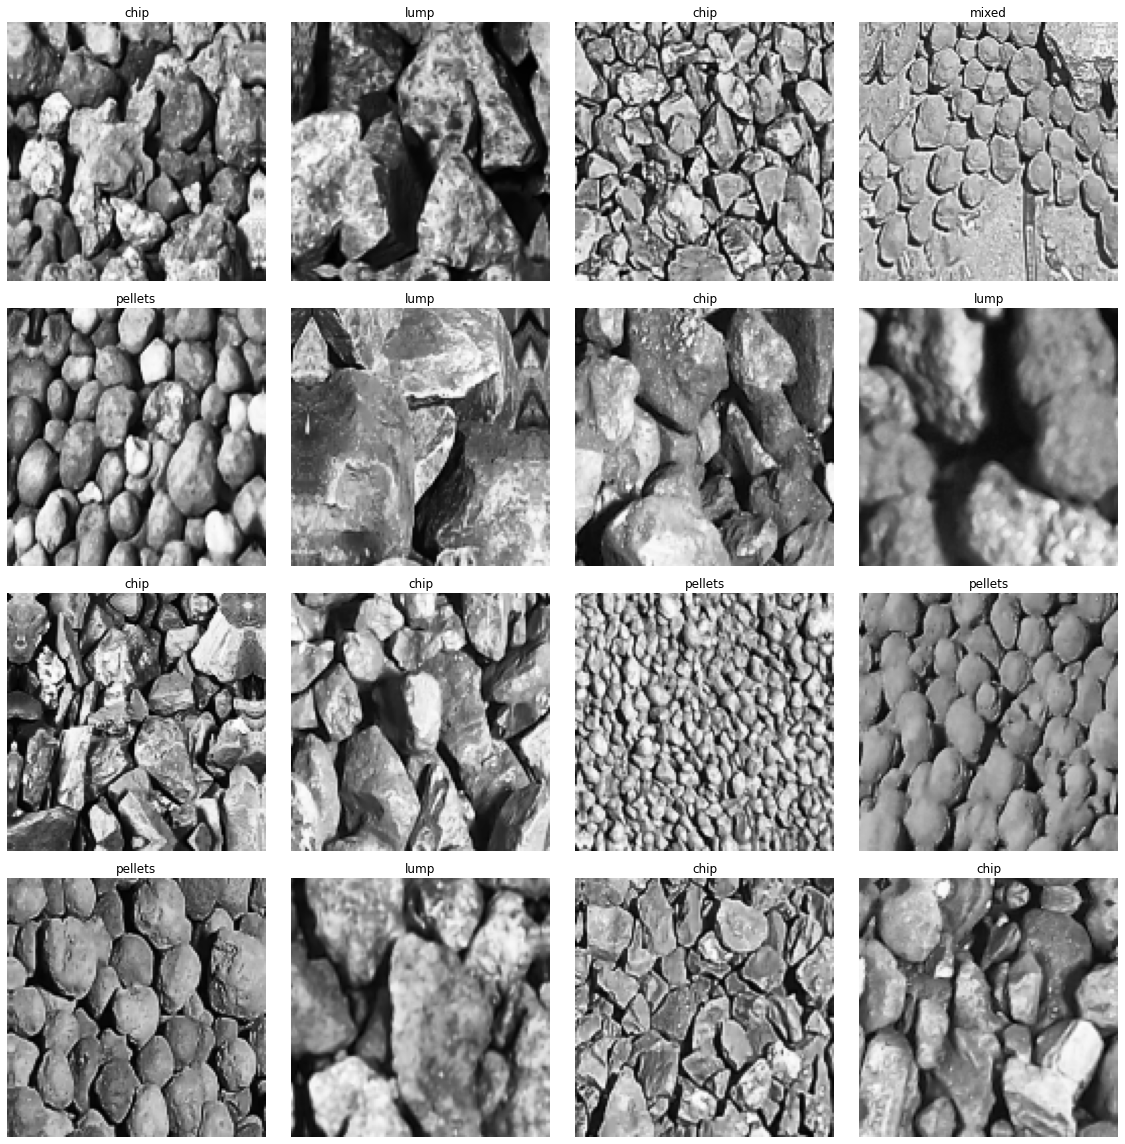

In [ ]:
#Creating the labelled image databunch with batch size 16 and image size 128, 128
batch_size = 16
train_image_size = (128, 128)
image_dir = Path("/content/gdrive/My Drive/data_final/DATA FINAL/")
tfms = get_transforms()
labeled_data = ImageDataBunch.from_folder(image_dir, train = '.',
                                   ds_tfms=tfms,size=train_image_size,valid_pct = 0.2, bs = batch_size).normalize(imagenet_stats)

labeled_data.show_batch()

In [ ]:
#run fixMatch code
%run "/content/gdrive/Shared drives/DSI Module 2 Team Drive /Computer Vision Challenge Shared Folder/Fixmatch Notebooks/Fixmatch.ipynb"

In [ ]:
#path to the set of unlabelled images which will be utilized by fixmatch
unlabelled_dir = Path("/content/gdrive/Shared drives/DSI Module 2 Team Drive /Data/samples/")

In [ ]:
# creating the unlabeld databunch using the function get_unlabeld data
def get_unlabeled_data(unlabeled_dir, labeled_data, n_augment=2, batch_multiplier=2):
    u_image_list = ImageList.from_folder(unlabeled_dir).split_none()
    u_image_list.train._label_list = partial(MultiTfmPairLabelList, K=n_augment, 
                                             weak_tfms=get_weak_transforms(), strong_tfms=get_strong_transforms(),
                                             extra_strong_tfms=get_extra_strong_transforms())
    u_databunch = (u_image_list.label_empty()
        .databunch(
            bs=labeled_data.batch_size * batch_multiplier,
            collate_fn=MultiCollate)
        .normalize(labeled_data.stats))
    u_databunch.c = 1
    return u_databunch
    
unlabeled_data = get_unlabeled_data(unlabelled_dir, labeled_data, batch_multiplier=2)

print(unlabeled_data)

ImageDataBunch;

Train: MultiTfmPairLabelList (22303 items)
x: ImageList
(Image (3, 128, 128), tensor([[[0.3647, 0.5451, 0.6314,  ..., 0.3020, 0.1922, 0.3373],
         [0.3765, 0.5843, 0.6353,  ..., 0.3020, 0.2510, 0.4392],
         [0.4549, 0.5176, 0.5882,  ..., 0.2353, 0.2941, 0.4745],
         ...,
         [0.4039, 0.5490, 0.5176,  ..., 0.7608, 0.8784, 0.9294],
         [0.6039, 0.6863, 0.7176,  ..., 0.8275, 0.7608, 0.8314],
         [0.8314, 0.7765, 0.6706,  ..., 0.9098, 0.8392, 0.8039]],

        [[0.3647, 0.5451, 0.6314,  ..., 0.3020, 0.1922, 0.3373],
         [0.3765, 0.5843, 0.6353,  ..., 0.3020, 0.2510, 0.4392],
         [0.4549, 0.5176, 0.5882,  ..., 0.2353, 0.2941, 0.4745],
         ...,
         [0.4039, 0.5490, 0.5176,  ..., 0.7608, 0.8784, 0.9294],
         [0.6039, 0.6863, 0.7176,  ..., 0.8275, 0.7608, 0.8314],
         [0.8314, 0.7765, 0.6706,  ..., 0.9098, 0.8392, 0.8039]],

        [[0.3647, 0.5451, 0.6314,  ..., 0.3020, 0.1922, 0.3373],
         [0.3765, 0.5843, 0.

To predict the pseudo-labels a model was chosen from the models previosuly trained on the labelled data. A few were tested and the 'resnet50' performed the best so this was selected. 

# Resnet50

In [ ]:
base_model = models.resnet50()
learn = Learner(labeled_data, base_model, metrics=accuracy).fixmatch(unlabeled_data)

labeled dataset     :         2,571 samples
unlabeled dataset   :        22,303 samples
labeled batch size: 16
unlabeled batch size: 32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 2.51E-02


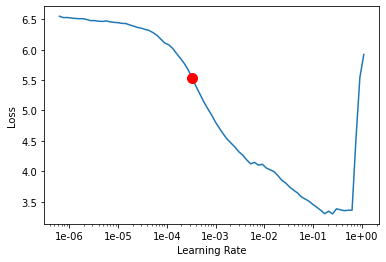

In [ ]:
#finding the optimal learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# training model
resnet_learning_rate = 1e-03
learn.fit_one_cycle(15, resnet_learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [ ]:
#Export model
learn.export('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Computer Vision Challenge Shared Folder/Fixmatch Notebooks/models/res50_fix.pkl')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

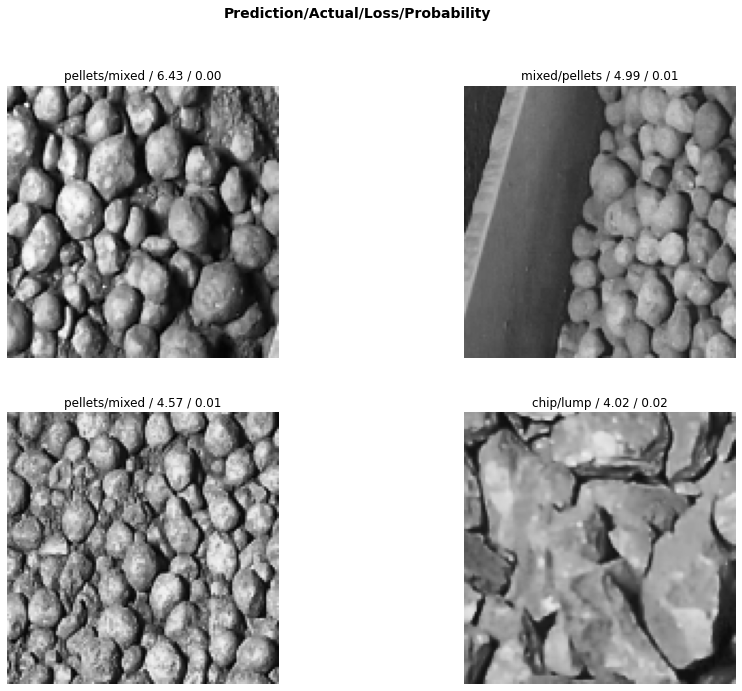

In [ ]:
# interpreting our model's performance
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

interp.plot_top_losses(4, figsize=(15,11))

In [ ]:
# checking for the most confused
interp.most_confused(min_val = 2)

[('lump', 'chip', 15),
 ('chip', 'lump', 7),
 ('mixed', 'lump', 7),
 ('mixed', 'pellets', 7),
 ('mixed', 'chip', 5),
 ('mixed', 'fines', 3),
 ('pellets', 'mixed', 3),
 ('chip', 'mixed', 2),
 ('chip', 'pellets', 2)]

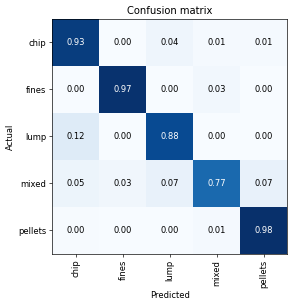

In [ ]:
# plotting the confusion matrix
interp.plot_confusion_matrix(figsize=(5,5), dpi=60, normalize = True)

# Resnet 101

In [ ]:
base_model = models.resnet101()
learn = Learner(labeled_data, base_model, metrics=accuracy).fixmatch(unlabeled_data)

labeled dataset     :         2,571 samples
unlabeled dataset   :        22,303 samples
labeled batch size: 16
unlabeled batch size: 32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 1.45E-02


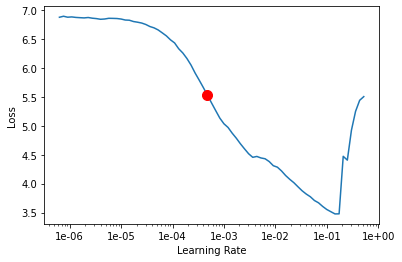

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learning_rate = 1e-03
learn.fit_one_cycle(15, learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

KeyboardInterrupt: ignored

In [ ]:
#Export model
learn.export('/content/gdrive/Shared drives/DSI Module 2 Team Drive /Computer Vision Challenge Shared Folder/Fixmatch Notebooks/models/res101_fix.pkl')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

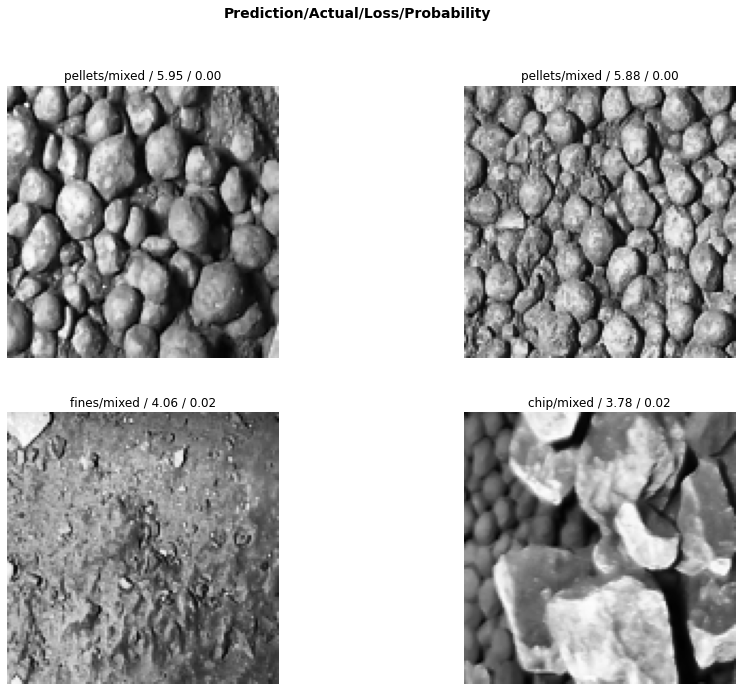

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

interp.plot_top_losses(4, figsize=(15,11))

In [ ]:
interp.most_confused(min_val = 2)

[('lump', 'chip', 14),
 ('mixed', 'pellets', 11),
 ('mixed', 'chip', 7),
 ('chip', 'lump', 5),
 ('mixed', 'fines', 4),
 ('mixed', 'lump', 4),
 ('chip', 'mixed', 3),
 ('lump', 'mixed', 2)]

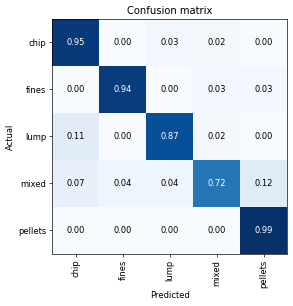

In [ ]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60, normalize = True)

# Submission

In [ ]:
test = ImageList.from_folder('/content/gdrive/My Drive/samp/')

In [ ]:
learn = load_learner(Path('/content/drive/Shared drives/DSI Module 2 Team Drive /models/'), 'rock-class-1.pth', test=test)

In [ ]:
predicted_probs, _ = learn.TTA(ds_type = fastai.basic_data.DatasetType.Test)
predicted_probs, y = learn.get_preds(ds_type = fastai.basic_data.DatasetType.Test)

_, predicted_classes = predicted_probs.max(dim=1)
class_labels = np.array(['chip', 'fines', 'lump', 'mixed', 'pellets'])
predicted_class_labels = class_labels[predicted_classes]

filenames = np.array([item.name for item in test.items])
submission = (pd.DataFrame.from_dict({'Id': filenames, 'Category': predicted_class_labels,}))
sub_file = './drive/My Drive/submission_file.csv'
submission.to_csv(sub_file, header=True, index=False)

# Conclusion


The model that seemed to perfrom better than the others was Resnet101. Given more time, we could have tried ensembling the models to get better results. 